In [1]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [2]:
#para leer un archivo Yaml en Python

try:
    with open (r"C:\Users\perez\OneDrive\Documentos\GitHub\Proyectos\vanguard_project\vanguard\config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [3]:
df_final_demo = pd.read_csv(config['data']['demo_final'], sep=",", header=0,low_memory=False)

In [4]:
df_final_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


clnt_tenure_yr = tiempo que lleva siendo cliente en años
clnt_tenure_mnth = tiempo que lleva siendo cliente en meses
clnt_age = edad
gendr = género
num_accts = número de cuentas que tiene el cliente
bal = saldo total que se reparte entre las dos cuentas del cliente
calls_6_mnth = veces que el cliente se comunicó a través de una llamada en los últimos 6 meses
logons_6_mnth = frecuencia con que el cliente ingresa en la plataforma los últimos 6 meses

In [5]:
df_final_demo.shape

(70609, 9)

In [6]:
df_final_demo.dtypes

client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
dtype: object

In [7]:
#miramos las columnas que son numéricas

df_final_demo.select_dtypes("number").columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [8]:
#sacamos los valores únicos para las columnas con datos numéricos

df_final_demo.select_dtypes("number").nunique().sort_values(ascending=False)

client_id           70609
bal                 70328
clnt_tenure_mnth      482
clnt_age              165
clnt_tenure_yr         54
logons_6_mnth           9
num_accts               8
calls_6_mnth            8
dtype: int64

In [9]:
#vemos la columna con datos categóricos

df_final_demo.select_dtypes("object").columns

Index(['gendr'], dtype='object')

In [10]:
#comprobamos si hay valores nulos

df_final_demo.isnull().sum()

client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64

In [11]:
#calcular los principales clientes basados en el dinero total de sus cuentas
clientes_principales = df_final_demo.groupby('client_id')['bal'].sum().nlargest(50)

In [12]:
#filtramos el dataframe original solo para los clientes principales

df_clientes_principales = df_final_demo[df_final_demo['client_id'].isin(clientes_principales.index)]

In [13]:
df_clientes_principales.head(2)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
2171,2291985,7.0,85.0,41.0,M,2.0,8247729.97,1.0,4.0
6406,4179430,9.0,117.0,66.5,M,2.0,4635079.65,6.0,9.0


In [14]:
#calculamos la frecuencia de cada uno de los géneros para los clientes principales

frecuencia_genero = df_clientes_principales['gendr'].value_counts()
frecuencia_genero

gendr
M    40
F     9
U     1
Name: count, dtype: int64

In [15]:
#calculamos la proporción de cada uno de los géneros

proporcion_genero = df_clientes_principales['gendr'].value_counts(normalize=True)
proporcion_genero

gendr
M    0.80
F    0.18
U    0.02
Name: proportion, dtype: float64

In [16]:
df_clientes_principales.select_dtypes("number").describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,5.407329e+06,17.980000,221.260000,57.580000,3.000000,5.731276e+06,5.420000,7.780000
std,3.022354e+06,8.636633,103.933222,10.704929,0.903508,2.292440e+06,1.371577,1.787599
min,1.296590e+05,4.000000,58.000000,26.500000,2.000000,3.986272e+06,1.000000,2.000000
25%,2.452809e+06,11.000000,134.500000,54.000000,2.000000,4.466770e+06,5.000000,7.000000
50%,6.008444e+06,17.500000,215.500000,59.000000,3.000000,4.734690e+06,6.000000,9.000000
75%,8.004878e+06,24.000000,296.500000,65.375000,3.000000,6.378546e+06,6.000000,9.000000
max,9.990452e+06,37.000000,451.000000,74.500000,6.000000,1.632004e+07,7.000000,9.000000


In [17]:
#calculamos la media, la mediana y la moda del dinero en cuenta de los principales clientes

media_de_dinero = df_clientes_principales['bal'].mean()
mediana_de_dinero = df_clientes_principales['bal'].median()
moda_de_dinero = df_clientes_principales['bal'].mode()

media_de_dinero, mediana_de_dinero

(5731276.075200001, 4734689.994999999)

In [18]:
std_de_dinero = df_clientes_principales['bal'].std()
var_de_dinero = df_clientes_principales['bal'].var()
min_de_dinero = df_clientes_principales['bal'].min()
max_de_dinero = df_clientes_principales['bal'].max()

std_de_dinero, var_de_dinero, min_de_dinero, max_de_dinero

(2292440.3162921155, 5255282603761.495, 3986272.4, 16320040.15)

In [19]:
rango_de_dinero = max_de_dinero - min_de_dinero
quantiles_de_dinero = df_clientes_principales['bal'].quantile([0.25, 0.5, 0.75])

rango_de_dinero, quantiles_de_dinero

(12333767.75,
 0.25    4.466770e+06
 0.50    4.734690e+06
 0.75    6.378546e+06
 Name: bal, dtype: float64)

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


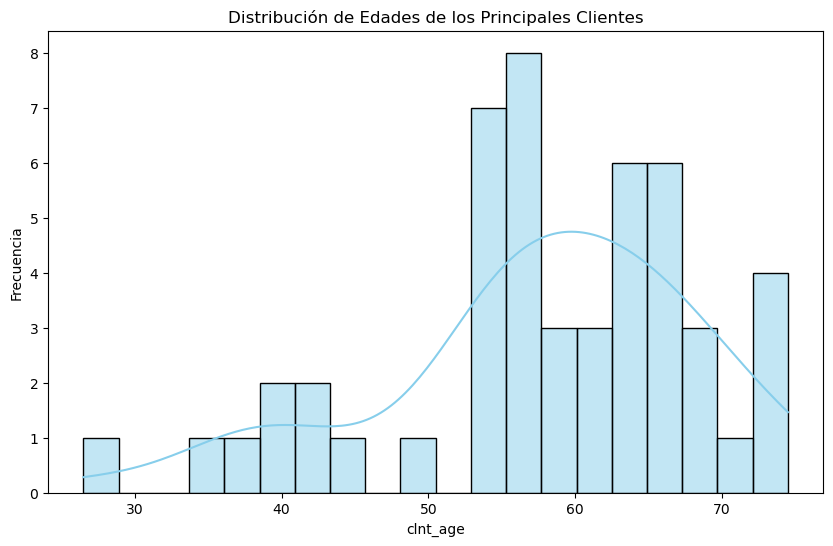

In [20]:
#Histograma de edades de los principales clientes

plt.figure(figsize=(10, 6))
sns.histplot(df_clientes_principales['clnt_age'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de Edades de los Principales Clientes')
plt.xlabel('clnt_age')
plt.ylabel('Frecuencia')
plt.show()

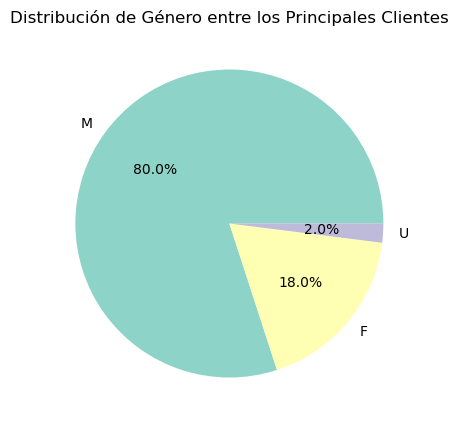

In [21]:
#creamos un gráfico circular para ver la distribución de géneros en los principales clientes
plt.figure(figsize=(5, 5))
plt.pie(frecuencia_genero, labels=frecuencia_genero.index, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Distribución de Género entre los Principales Clientes')
plt.show()

<Axes: xlabel='gendr'>

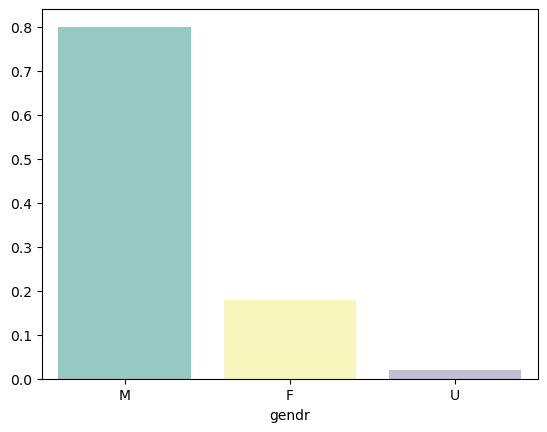

In [22]:
#creamos gráfico de barras de la proporción del género entre los principales clientes

sns.barplot(x=proporcion_genero.index, y=proporcion_genero.values, palette='Set3')

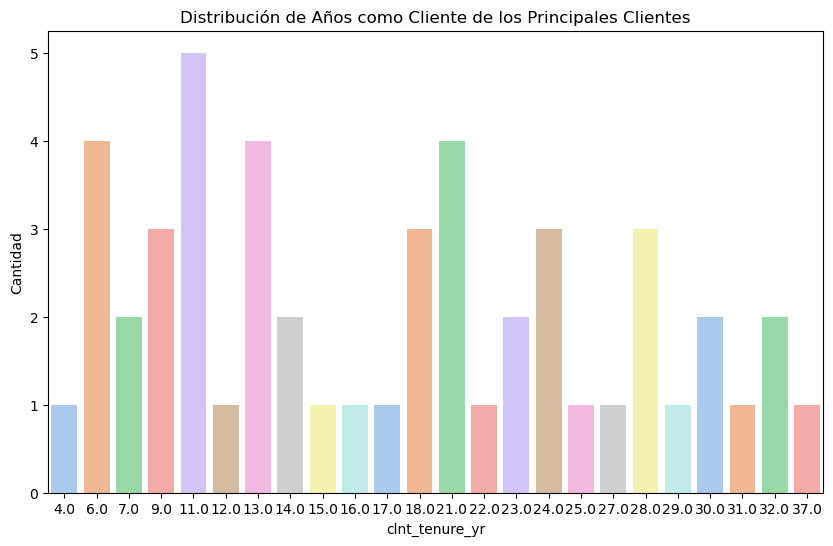

In [23]:
#Gráfico de barras de años que llevan como clientes los principales clientes
plt.figure(figsize=(10, 6))
sns.countplot(x='clnt_tenure_yr', data=df_clientes_principales, palette='pastel')
plt.title('Distribución de Años como Cliente de los Principales Clientes')
plt.xlabel('clnt_tenure_yr')
plt.ylabel('Cantidad')
plt.show()

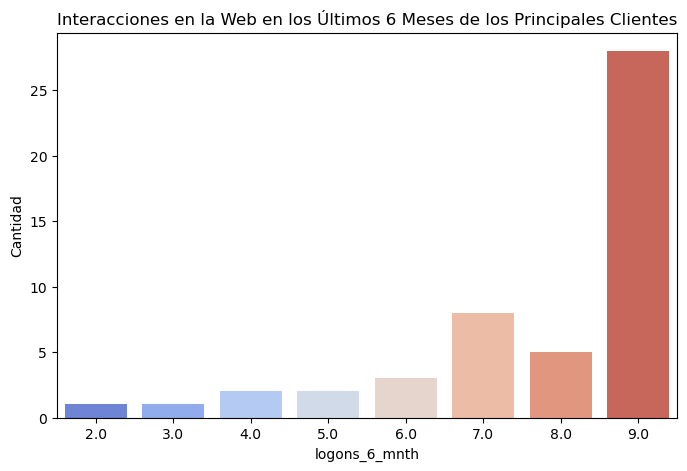

In [24]:
# Gráfico de barras de interacciones en la web en los últimos 6 meses de los principales clientes
plt.figure(figsize=(8, 5))
sns.countplot(x='logons_6_mnth', data=df_clientes_principales, palette='coolwarm')
plt.title('Interacciones en la Web en los Últimos 6 Meses de los Principales Clientes')
plt.xlabel('logons_6_mnth')
plt.ylabel('Cantidad')
plt.show()

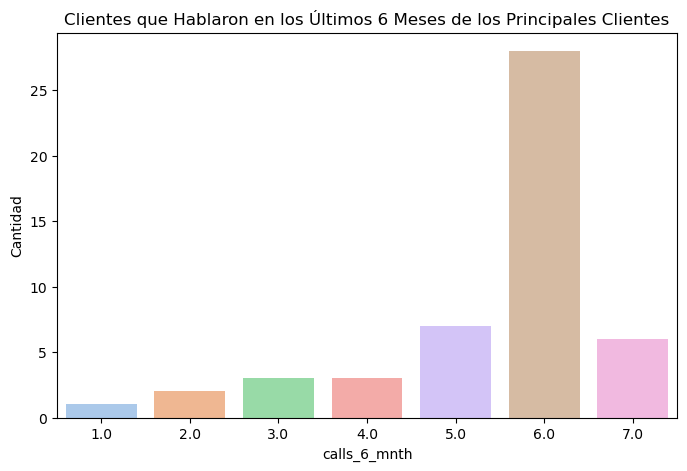

In [25]:
# Gráfico de barras de clientes que hablaron en los últimos 6 meses de los principales clientes
plt.figure(figsize=(8, 5))
sns.countplot(x='calls_6_mnth', data=df_clientes_principales, palette='pastel')
plt.title('Clientes que Hablaron en los Últimos 6 Meses de los Principales Clientes')
plt.xlabel('calls_6_mnth')
plt.ylabel('Cantidad')
plt.show()

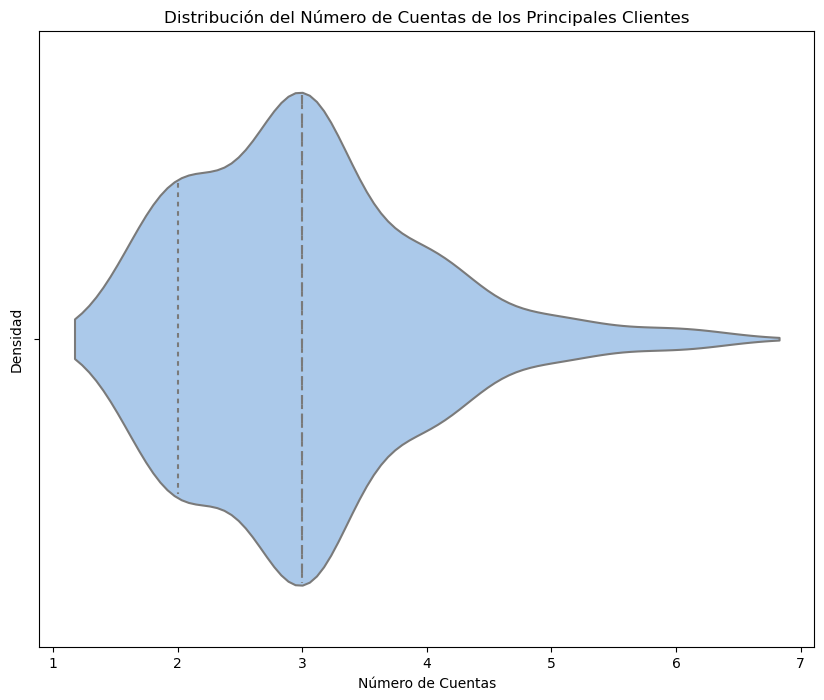

In [26]:
plt.figure(figsize=(10, 8))
sns.violinplot(x=df_clientes_principales['num_accts'], inner='quartile', palette='pastel')
plt.title('Distribución del Número de Cuentas de los Principales Clientes')
plt.xlabel('Número de Cuentas')
plt.ylabel('Densidad')
plt.show()

¿Quiénes son los clientes principales?
¿Son los clientes principales jovenes o mayores, nuevos o clientes fieles?

La edad media de los clientes principales es de 58 años con una deviación estándar de tan solo 10, valor mínimo de 27 y máximo de 75.
Por lo que concluimos que la mayor parte de clientes principales tienen una edad avanzada.
En el gráfico de barras, podemos comprobar que, efectivamente, la mayor parte de los clientes principales tienen entre 50 y 70 años.

Los clientes principales son mayoritariamente hombres (80%), tan solo un 18% son mujeres y un 2% NS/NC.

Los clientes principales llevan siéndolo de media 18 años, así que suelen ser clientes fieles.
Aunque la desviación estándar es alta, de 9, y el valor mínimo de 4 y máximo de 37, por lo que también asumimos que hay mucha variación en este dato. El gráfico de barras nos ayuda a confirmar esta primera hipótesis.

La media de cuentas que tienen es de 3.
El mínimo de cuentas a su nombre son 2 y el máximo son 6, aunque la desviación estándar es menor a 1, por lo que asumimos que la mayor parte de clientes principales tienen alrededor de 3 cuentas.
En el gráfico de violín se ve claramente que la mayor parte de los clientes principales tiene 3 cuentas y, en menor, medida, 2.

El dinero de media en la cuenta para los clientes principales es de 5.731.276 dólares, mientras que la moda es 31.188 dólares.
El mínimo de dinero en cuenta es de 3.986.272 dólares y el máximo es de 16.320.040 dólares y la desviación estándar de 2.262.440 indican que hay mucha variación en el dinero en cuenta.
No obstante, el dinero en cuenta de los clientes principales es muy elevado.

La distribución del dinero en cuenta está sesgada a la derecha, por lo que hay elevado dinero (skewness de 2.8) y el valor de kurtosis por encima de 3 (9.8) indica la existencia de outliers.

En el gráfico de caja vemos que los que tienen mayor cantidad de dinero de media son los que tienen dos cuentas, seguidos de los de 3. Después de este gráfico, pensamos que debemos eliminar los outliers para dinero en cuenta y los que tienen 6 cuentas.

La mayor parte de clientes principales ha accedido 9 veces a la plataforma en los últimos 6 meses y la mayor parte de los clientes principales ha contactado con la empresa vía telefónica 6 veces. 


In [28]:
#calculamos la matriz de correlación para crear un mapa de calor que muestre la relación entre todas las variables

#convertimos variables categóricas en variables dummy
df_dummies = pd.get_dummies(df_clientes_principales)

#calculamos la matriz de correlación
matriz_de_correlacion_1 = df_dummies.corr()

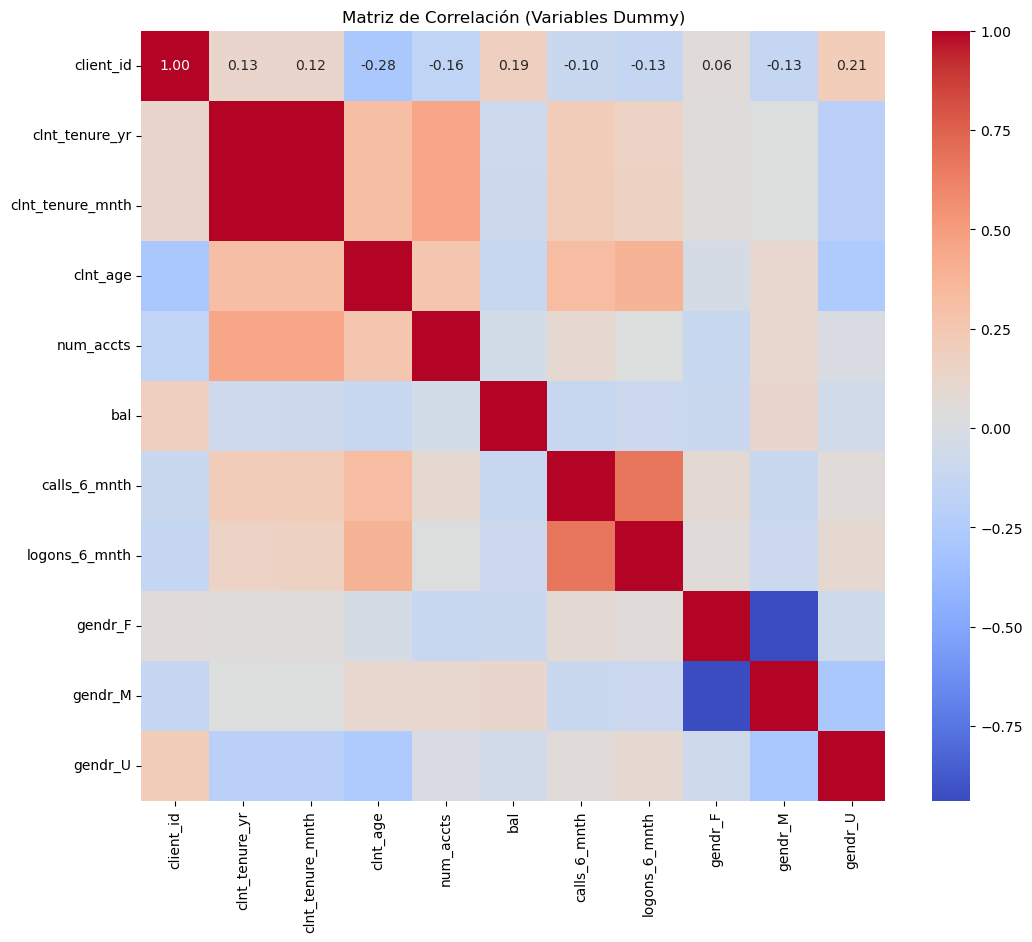

In [29]:
#creamos el heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(matriz_de_correlacion_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (Variables Dummy)')
plt.show()

In [27]:
#calculamos la matriz de correlación para crear un mapa de calor que muestre la relación entre variables numéricas

matriz_de_correlacion = df_clientes_principales[['bal', 'clnt_age', 'num_accts']].corr()

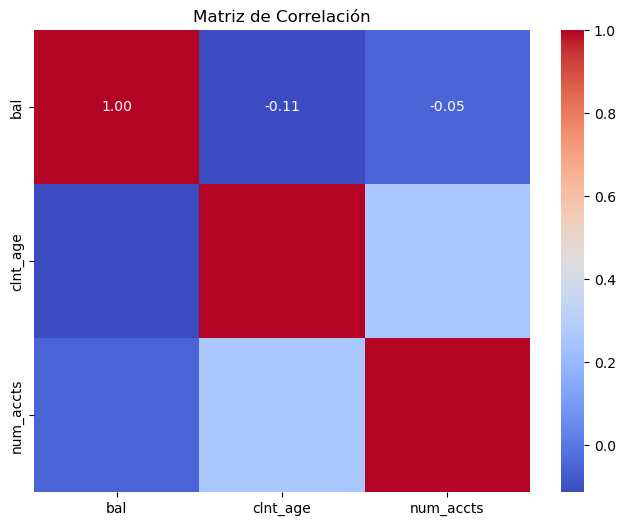

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_de_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [32]:
#vemos que hay más relación entre el número de cuentas y el dinero en cuenta
#también hay cierta relación aunque menos entre la edad del cliente y el dinero en cuenta

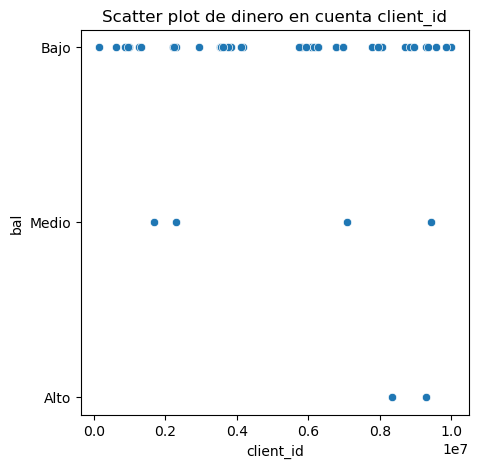

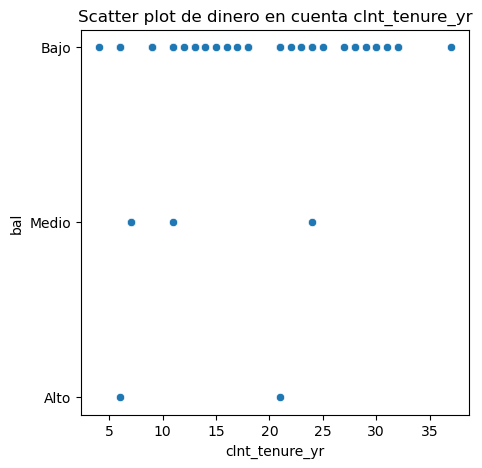

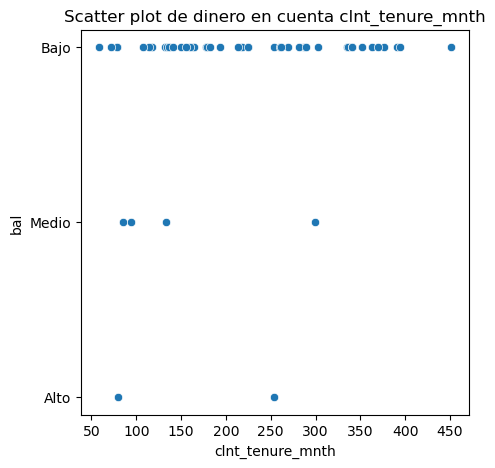

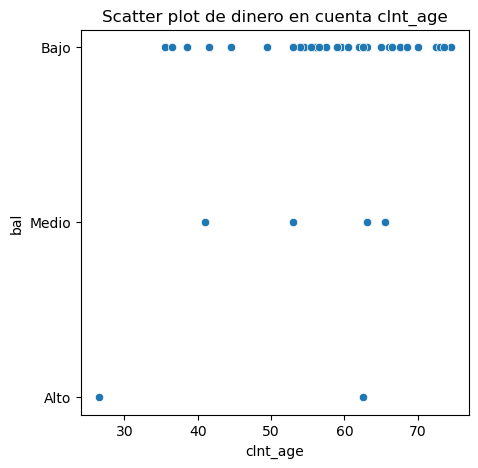

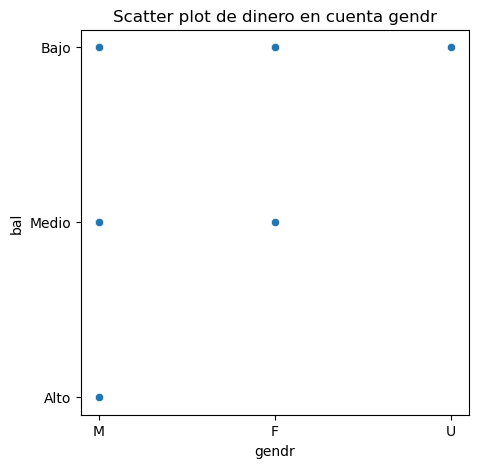

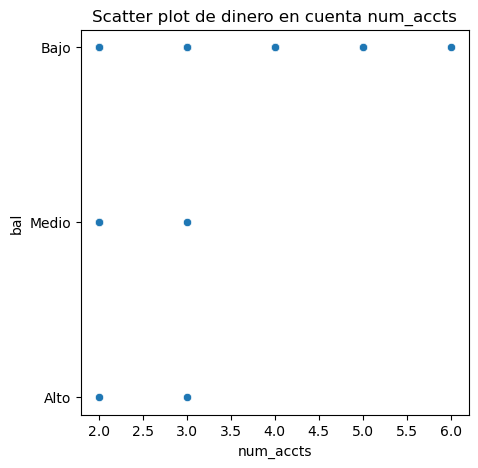

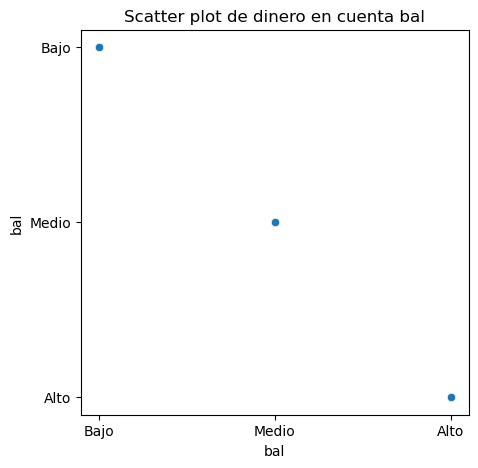

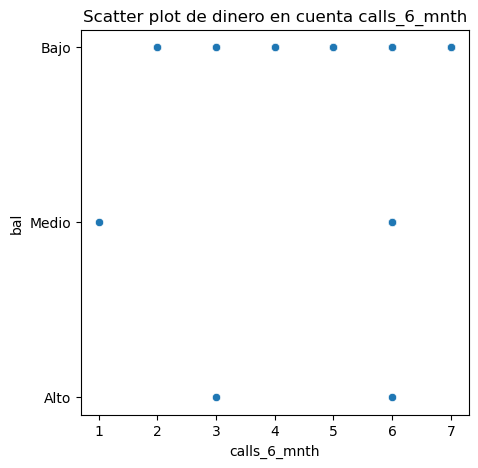

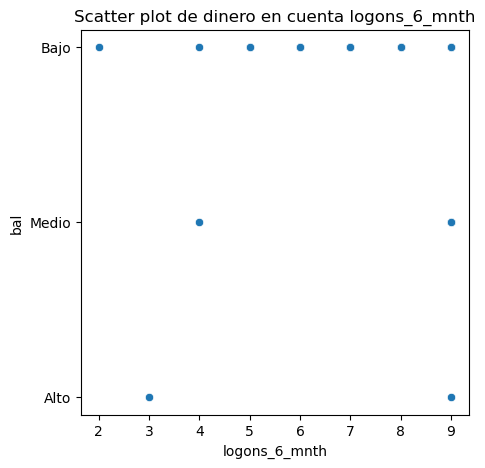

In [41]:
#hacemos un scatter plot para cada columna numérica contra 'bal' (dinero en cuenta) para visualizar la relación

for col in df_clientes_principales.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot de dinero en cuenta ' + col)
    sns.scatterplot(data=df_clientes_principales, x=col, y='bal')
    plt.show()

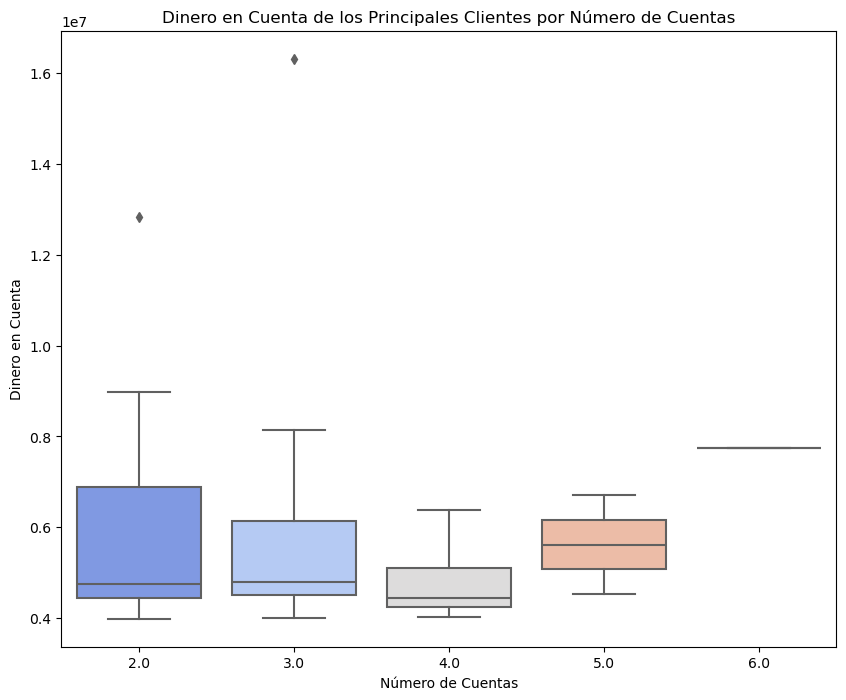

In [162]:
plt.figure(figsize=(10, 8))
sns.boxplot(x=df_clientes_principales['num_accts'], y=df_clientes_principales['bal'], palette='coolwarm')
plt.title('Dinero en Cuenta de los Principales Clientes por Número de Cuentas')
plt.xlabel('Número de Cuentas')
plt.ylabel('Dinero en Cuenta')
plt.show()

In [193]:
#calculamos skewness y kurtosis para ver outliers del dinero en cuenta

skewness_dinero_en_cuenta = df_clientes_principales['bal'].skew()

kurtosis_dinero_en_cuenta = df_clientes_principales['bal'].kurtosis()

skewness_dinero_en_cuenta, kurtosis_dinero_en_cuenta

(2.7981877251024803, 9.757427336193642)

In [198]:
#eliminamos los outliers del dinero en cuenta

#calculamos el IQM

Q1 = df_clientes_principales['bal'].quantile(0.25)
Q3 = df_clientes_principales['bal'].quantile(0.75)
IQR = Q3 - Q1

#establecemos los límites de los outliers

limite_bajo = Q1 - 1.5 * IQR
limite_alto = Q3 + 1.5 * IQR

#identificamos los outliers y los filtramos de la tabla

df_clientes_principales = df_clientes_principales[(df_clientes_principales['bal'] >= limite_bajo) & (df_clientes_principales['bal'] <= limite_alto)]

#comprobamos que hemos eliminado 7 clientes principales al eliminar valores outliers
df_clientes_principales.shape


(43, 9)

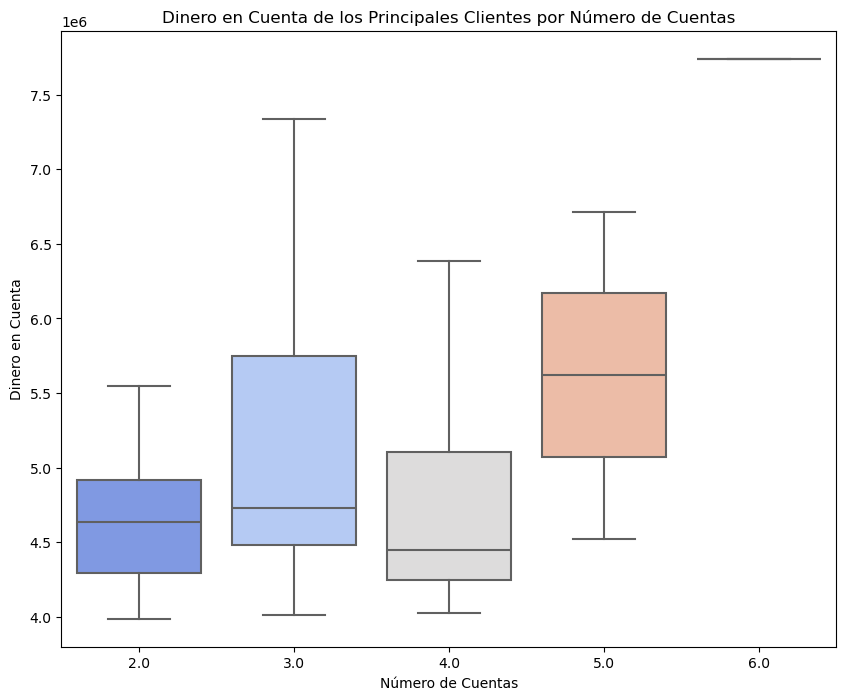

In [199]:
#volvemos a ver la relación entre dinero en cuenta y número de cuentas sin valores outliers

plt.figure(figsize=(10, 8))
sns.boxplot(x=df_clientes_principales['num_accts'], y=df_clientes_principales['bal'], palette='coolwarm')
plt.title('Dinero en Cuenta de los Principales Clientes por Número de Cuentas')
plt.xlabel('Número de Cuentas')
plt.ylabel('Dinero en Cuenta')
plt.show()

In [40]:
#calculamos la tabla de contigencia entre dinero en cuenta y número de cuentas

crosstab_1 = pd.crosstab(df_clientes_principales['bal'], df_clientes_principales['num_accts'])

In [41]:
#realizamos el chi-square test para ver si los valores dinero en cuenta y número de cuentas están relacionados

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_1)

chi2_statistic, chi2_p_value

(200.0, 0.40737781807064855)

In [ ]:
#según chi-square test no hay suficiente evidencia para decir que hay una asociación significativa entre las variables
#no calculamos la cramer's v effect size porque chi-square indica que no hay relación

In [44]:
#hacemos lo mismo con los siguientes valores a priori correlacionados: edad y dinero en la cuenta

1.0

In [63]:
#agrupamos la edad por grupos

bins = [0, 18, 36, 54, df_clientes_principales['clnt_age'].max()]
labels = ['niños', 'jóvenes', 'adultos jóvenes', 'adultos mayores']
df_clientes_principales['clnt_age'] = pd.cut(df_clientes_principales['clnt_age'], bins=bins, labels=labels, include_lowest=True)
df_clientes_principales.clnt_age.value_counts()

ValueError: bins must increase monotonically.

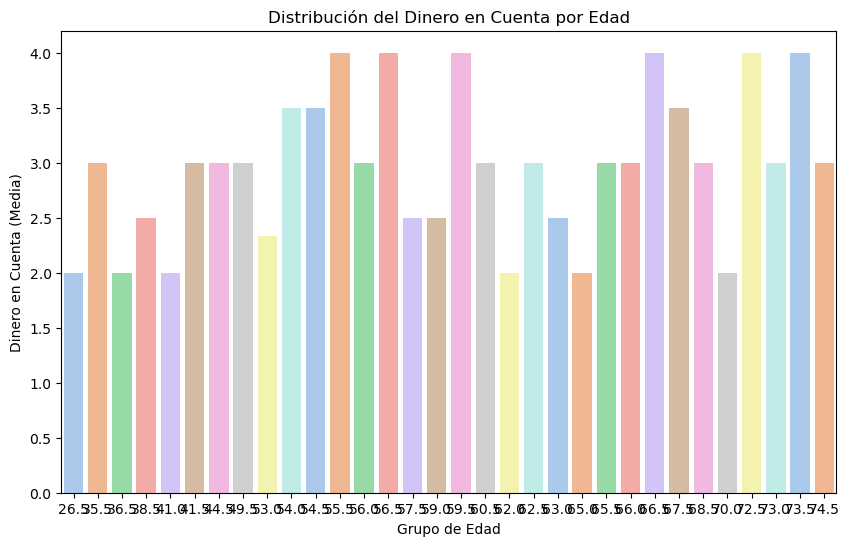

In [36]:
# Crear el gráfico de violín del dinero en cuenta por edad
plt.figure(figsize=(10, 6))
sns.barplot(x='clnt_age', y='num_accts', data=df_clientes_principales, palette='pastel', errorbar=None)
plt.title('Distribución del Dinero en Cuenta por Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Dinero en Cuenta (Media)')
plt.show()

In [31]:
#creamos una columna para el grupo de dinero en cuenta

df_clientes_principales['bal'] = pd.cut(df_clientes_principales['bal'], bins=3, labels=['Bajo', 'Medio', 'Alto'])

# Creamos el gráfico de barras apiladas
interacciones_web_por_dinero = df_clientes_principales.groupby(['bal', 'logons_6_mnth']).size().unstack()
interacciones_web_por_dinero.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])
plt.title('Interacciones en la Web por Nivel de Dinero en Cuenta')
plt.xlabel('Nivel de Dinero en Cuenta')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=45)
plt.legend(title='Interactuaron en la Web', loc='upper right')
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

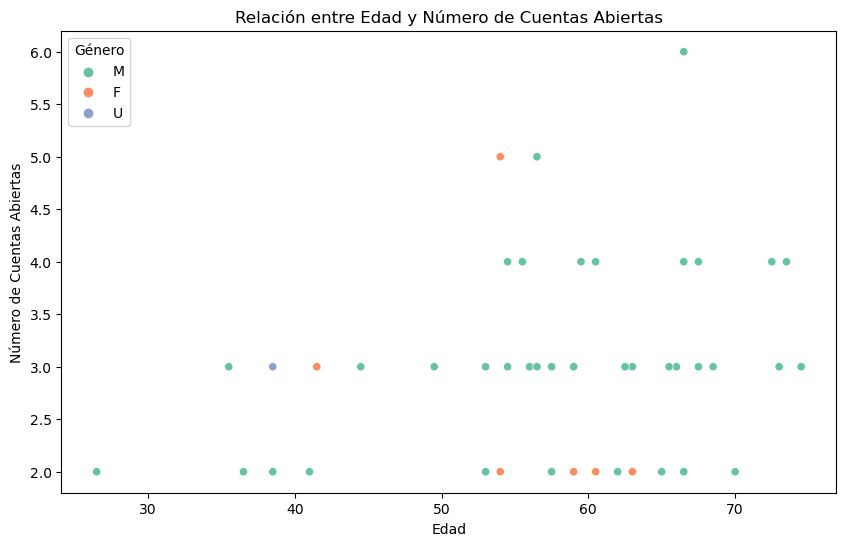

In [42]:
#creamos un gráfico de dispersión de edad, género y número de cuentas abiertas

plt.figure(figsize=(10, 6))
sns.scatterplot(x='clnt_age', y='num_accts', data=df_clientes_principales, hue='gendr', palette='Set2')
plt.title('Relación entre Edad y Número de Cuentas Abiertas')
plt.xlabel('Edad')
plt.ylabel('Número de Cuentas Abiertas')
plt.legend(title='Género', loc='upper left')
plt.show()

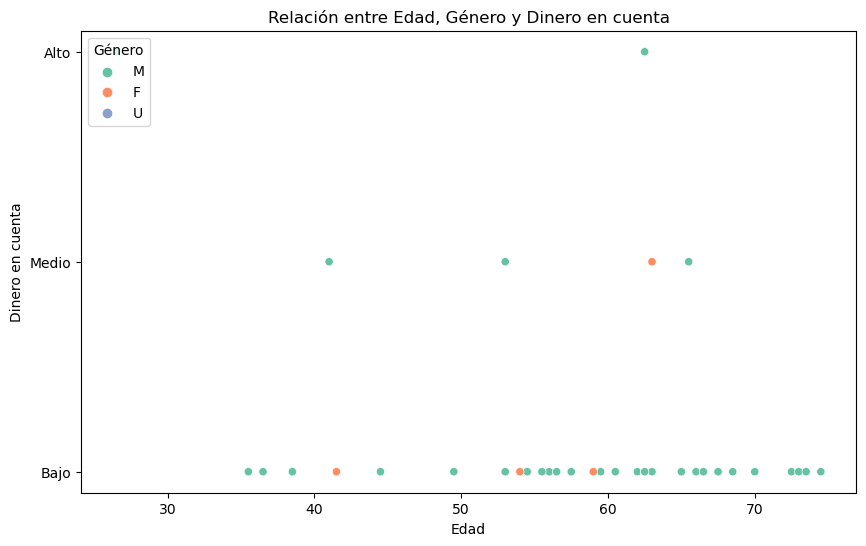

In [46]:
#creamos un gráfico de dispersión de edad, género y dinero en cuenta

plt.figure(figsize=(10, 6))
sns.scatterplot(x='clnt_age', y='bal', data=df_clientes_principales, hue='gendr', palette='Set2')
plt.title('Relación entre Edad, Género y Dinero en cuenta')
plt.xlabel('Edad')
plt.ylabel('Dinero en cuenta')
plt.legend(title='Género', loc='upper left')
plt.gca().invert_yaxis()
plt.show()

In [33]:
df_clientes_principales.head(1)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
2171,2291985,7.0,85.0,41.0,M,2.0,Medio,1.0,4.0


In [ ]:
crosstab_gender = pd.crosstab(df_clientes_principales[''])

In [18]:
#importamos los dos datasets de Huellas digitales y los fusionamos en un solo dataframe

pt_1 = pd.read_csv(config['data']['pt_1'], sep= ",", header=0, low_memory=False)

pt_2 = pd.read_csv(config['data']['pt_2'], sep= ",", header=0, low_memory=False)

df_final_web_data = pd.concat([pt_1, pt_2], axis=0).reset_index(drop=True)

In [19]:
#comprobamos cuántas filas tienen los datasets originales

pt_1.shape, pt_2.shape

((343141, 5), (412264, 5))

In [20]:
#comprobamos que se han sumado todas las filas de pt_2 y pt_1

df_final_web_data.shape

(755405, 5)

In [21]:
#previsualizamos las columnas y primeras filas

df_final_web_data.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [22]:
#vemos los tipos de data por defecto para cada columna

df_final_web_data.dtypes

client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object

In [23]:
#no hay valores nulos en ninguna columna y todos las columnas son de tipo objeto

df_final_web_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755405 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 28.8+ MB


In [24]:
#comprobamos el número de valores que tiene cada columna

df_final_web_data.nunique()

client_id       120157
visitor_id      130236
visit_id        158095
process_step         5
date_time       629363
dtype: int64

In [25]:
#confirmamos que no hay valores nulos

df_final_web_data.isnull().sum()

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [26]:
#comprobamos los duplicados

df_final_web_data.duplicated().sum()


10764

In [27]:
#eliminamos los 10764 valores duplicados

df_final_web_data.drop_duplicates(keep='first', inplace=True)

In [28]:
#comprobamos cuántas filas se han eliminado

df_final_web_data.shape

(744641, 5)

In [29]:
try:
    
    #cambiamos el formato de la columna 'date_time'.

    df_final_web_data["date_time"] = pd.to_datetime(df_final_web_data["date_time"], format='%Y-%m-%d %H:%M:%S')
    print("La columna date_time es de tipo datetime")
    
except ValueError:
        
    #Si la transformación da error el código arroja los valores problemáticos.

    print("Algunos valores en la columna no pudieron ser convertidos a date_time")
    print("Valores problemáticos:")
    problematic_values = df_final_web_data.loc[pd.to_datetime(df_final_web_data['date_time'], errors='coerce').isnull(), 'date_time']
    print(problematic_values)


La columna date_time es de tipo datetime


In [30]:
#comprobamos que, efectivamente, se ha modificado el tipo de datos para la columna data_type

df_final_web_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744641 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     744641 non-null  int64         
 1   visitor_id    744641 non-null  object        
 2   visit_id      744641 non-null  object        
 3   process_step  744641 non-null  object        
 4   date_time     744641 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.1+ MB


In [31]:
#comprobamos cuáles son los valores únicos de la columna process_step

df_final_web_data["process_step"].unique()

array(['step_3', 'step_2', 'step_1', 'start', 'confirm'], dtype=object)

In [46]:
#importar el dataframe de experiento

df_exp = pd.read_csv(config['data']['exp_client'], sep=",", header=0,low_memory=False)

In [47]:
#visualizamos el dataframe

df_exp

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [48]:
#Revisamos los tipos de data por defecto para cada columna
df_exp.dtypes

client_id     int64
Variation    object
dtype: object

In [49]:
#revisamos si hay datos duplicados y vemos que no hay 
df_exp.duplicated().sum()

0

In [50]:
# Revisamos si hay datos nulos 
df_exp.isnull().sum()

client_id        0
Variation    20109
dtype: int64

In [51]:
#eliminamos los datos nulos y con ellos se eliminan 20109 filas
df_null = df_exp.dropna(subset =["Variation"])

In [52]:
df_null

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test
